In [1]:
import pickle 
import arviz as az
import matplotlib.pyplot as plt
import pymc3 as pm
from pymc3 import Model, Normal, Slice, sample, traceplot
from pymc3.ode import DifferentialEquation
from scipy.integrate import odeint
import numpy as np
from matplotlib import rcParams
from scipy.stats import lognorm
import statsmodels.api as sm
import sunode

In [2]:
# dydt function
def cicr(y,t,p):  
    cyto=y[0]
    ER1=y[1]
    ER2=y[2]
    
    kSC=p[0]
    kRyr=p[1]
    kcomp=p[2]
    
    dcytodt = kRyr*ER2 - kSC*cyto
    dER1dt = kSC*cyto - kcomp*ER1
    dER2dt = kcomp*ER1 - kRyr*ER2
    
    return [dcytodt,dER1dt,dER2dt]

In [3]:
def cicrSunode(t,y,p): 
    return {
    'cyto': p.kRyr * y.ER2 - p.kSC * y.cyto,
    'ER1': p.kSC * y.cyto - p.kcomp * y.ER1,
    'ER2': p.kcomp * y.ER1 - p.kRyr * y.ER2}


In [4]:
# read in expt data
exptDat = np.genfromtxt('exptData.csv', delimiter=',',skip_header=1)
frameRate=6.0e-3 # sec


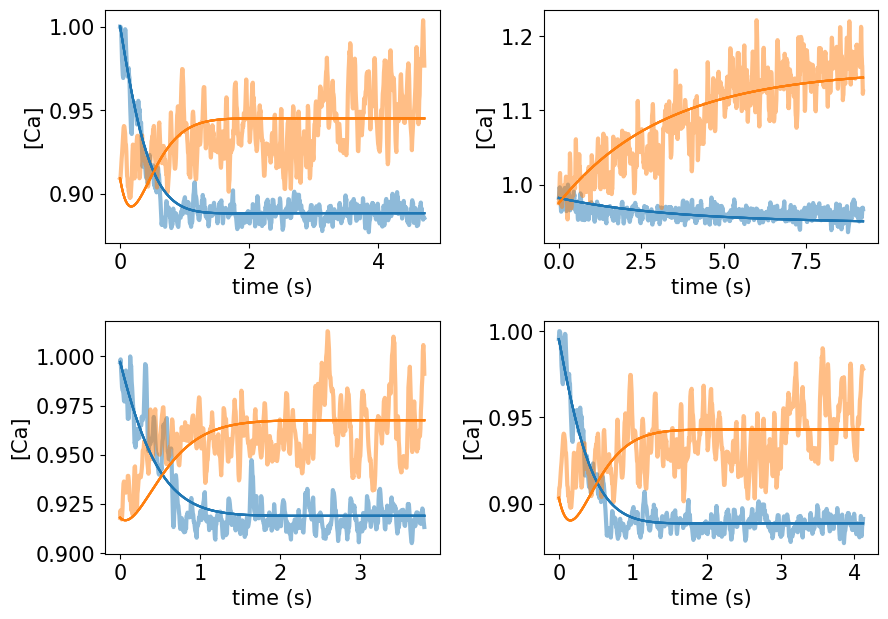

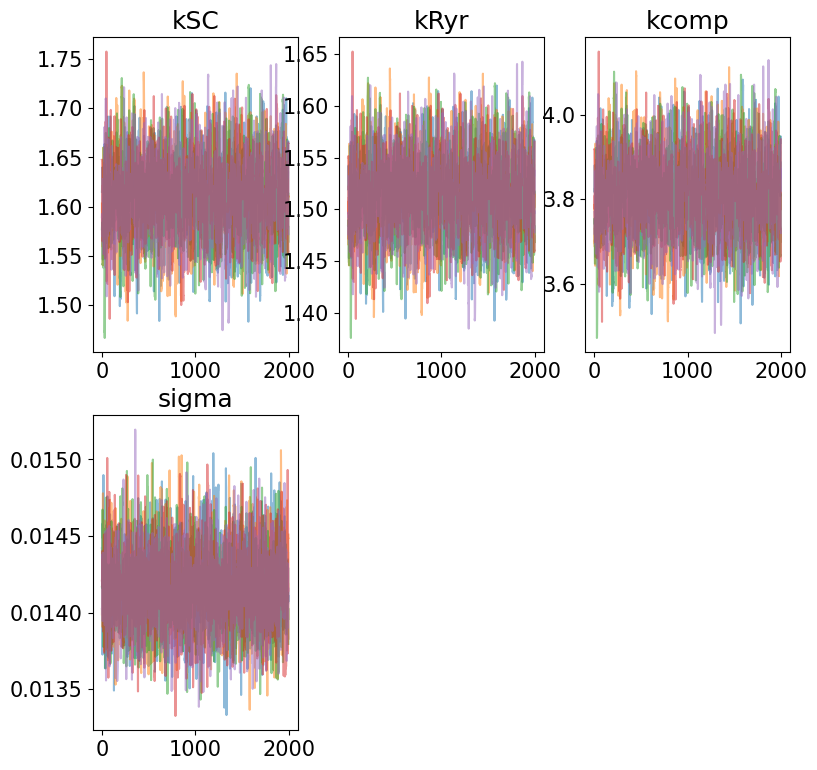

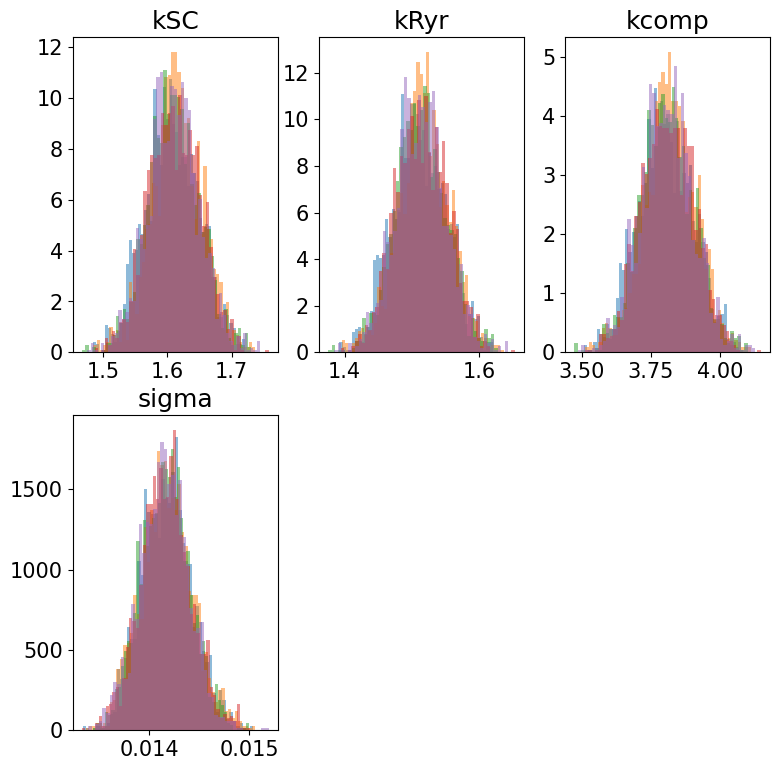

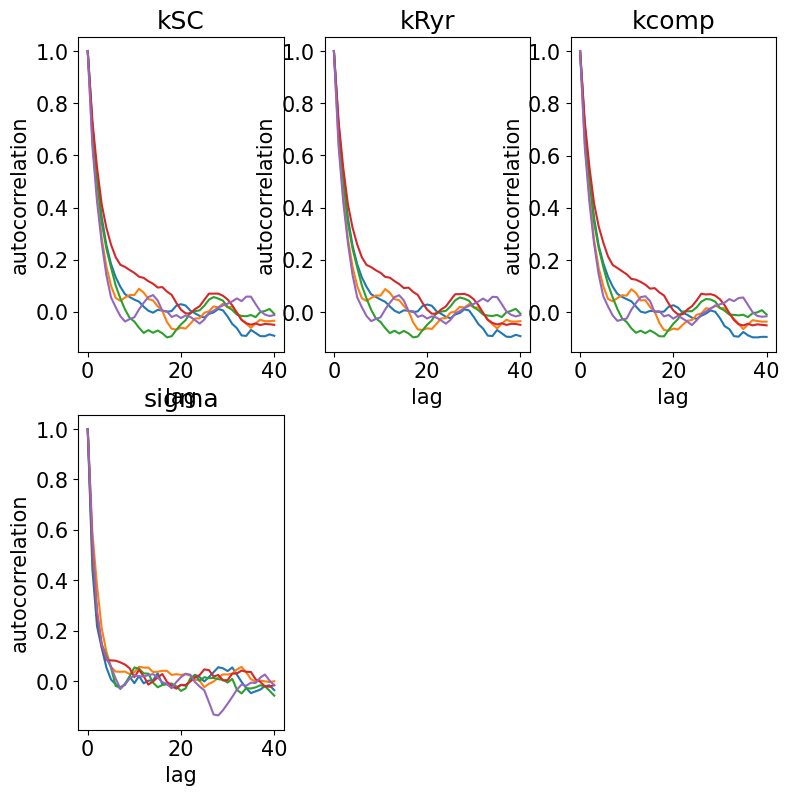

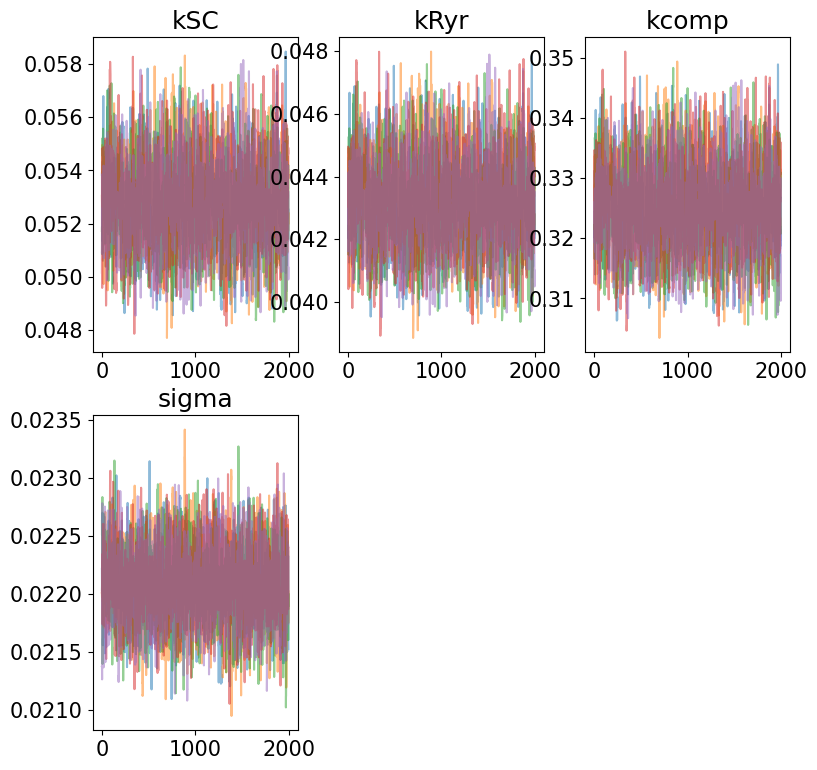

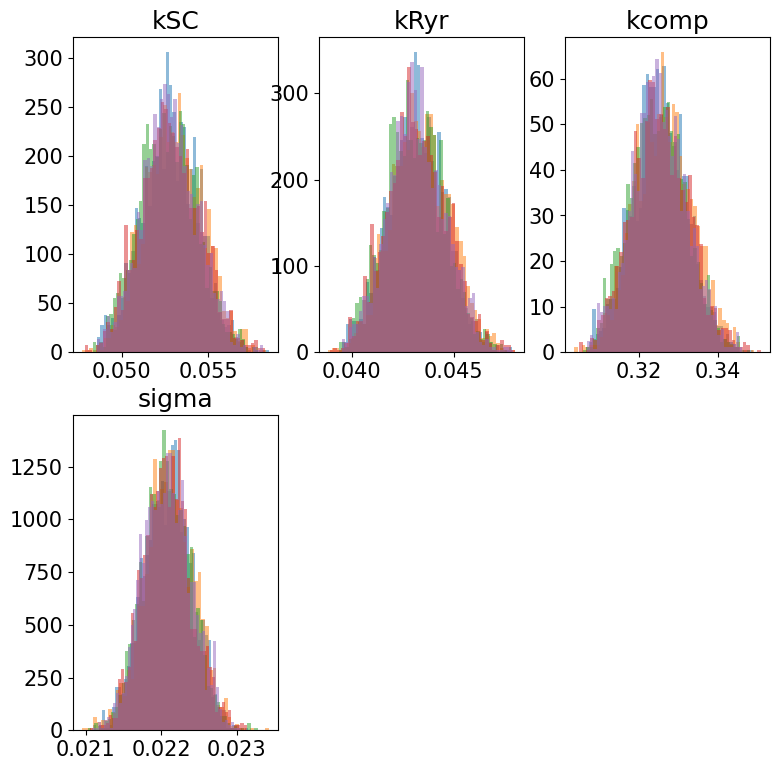

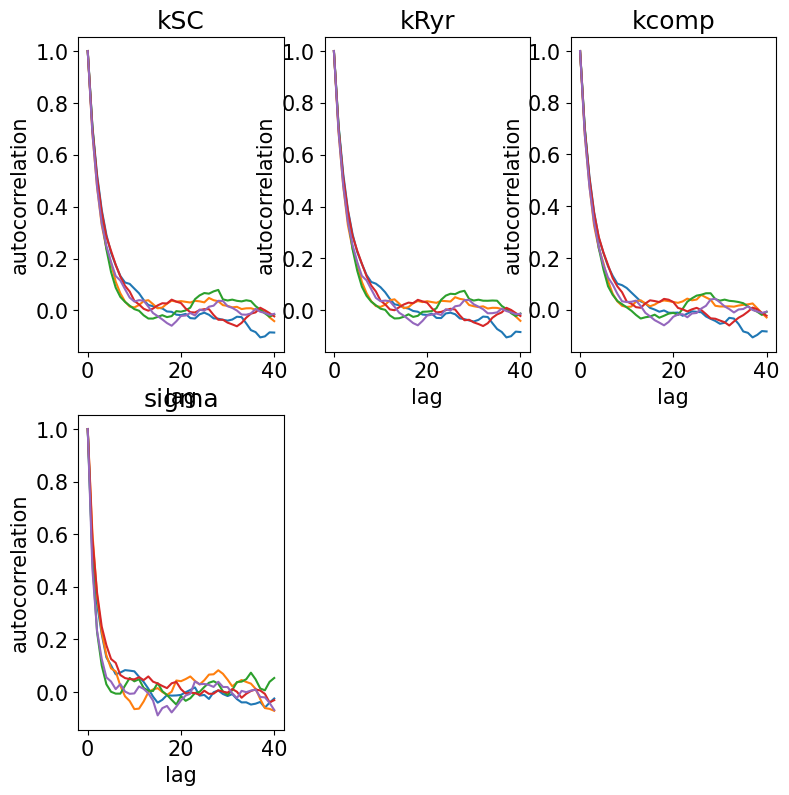

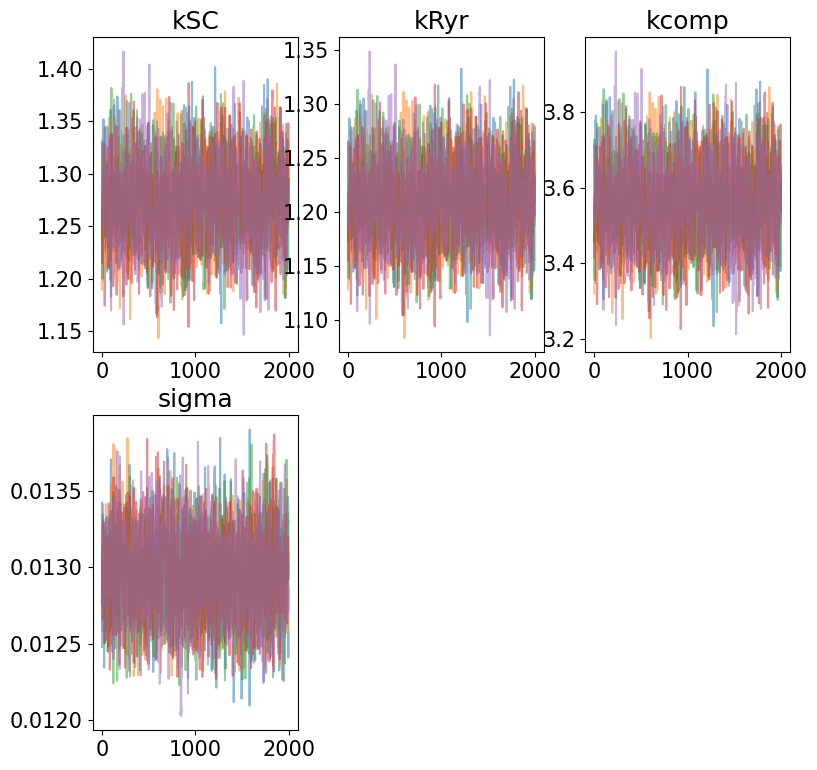

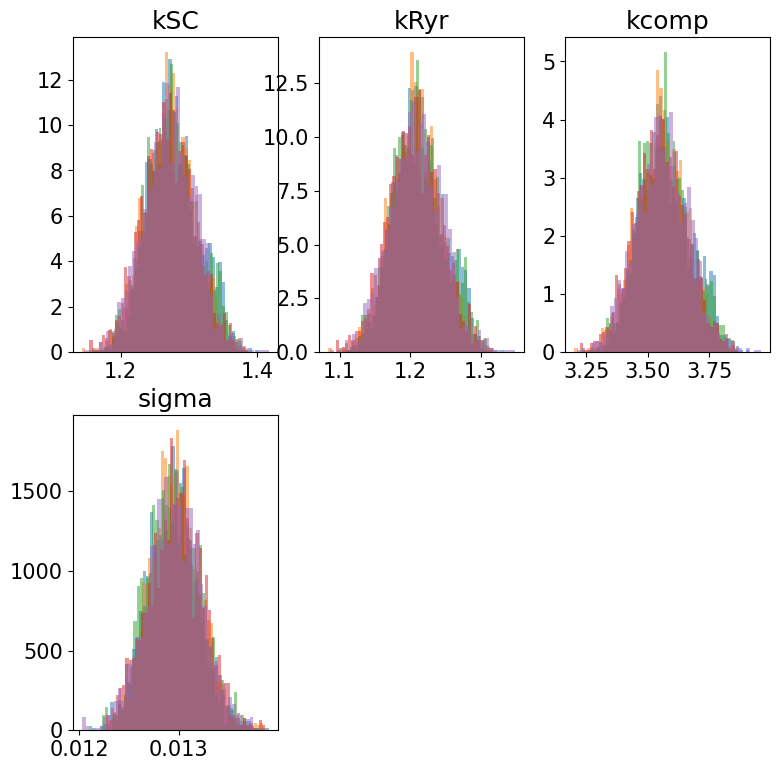

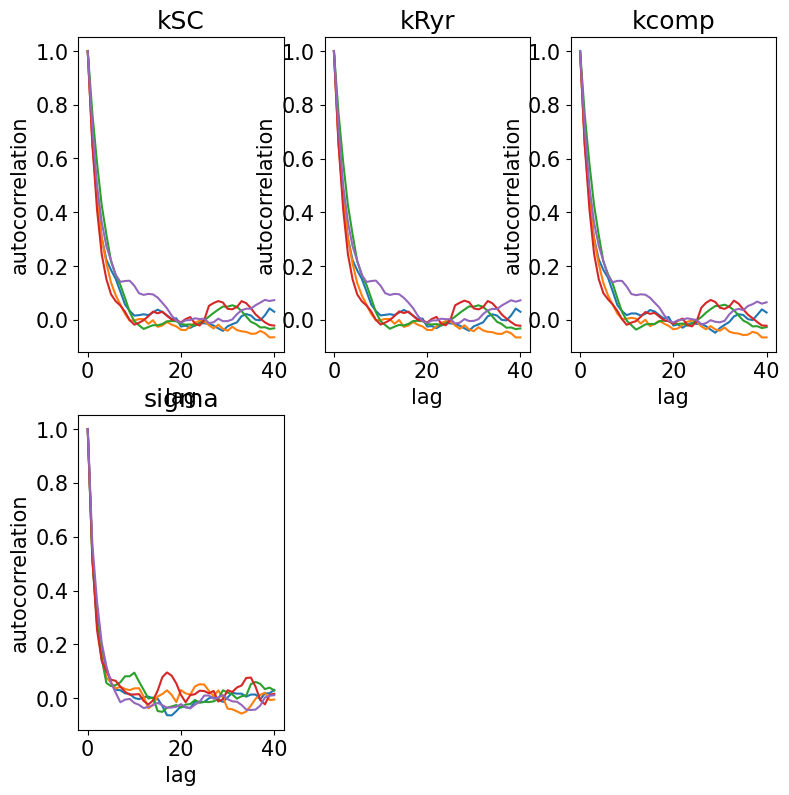

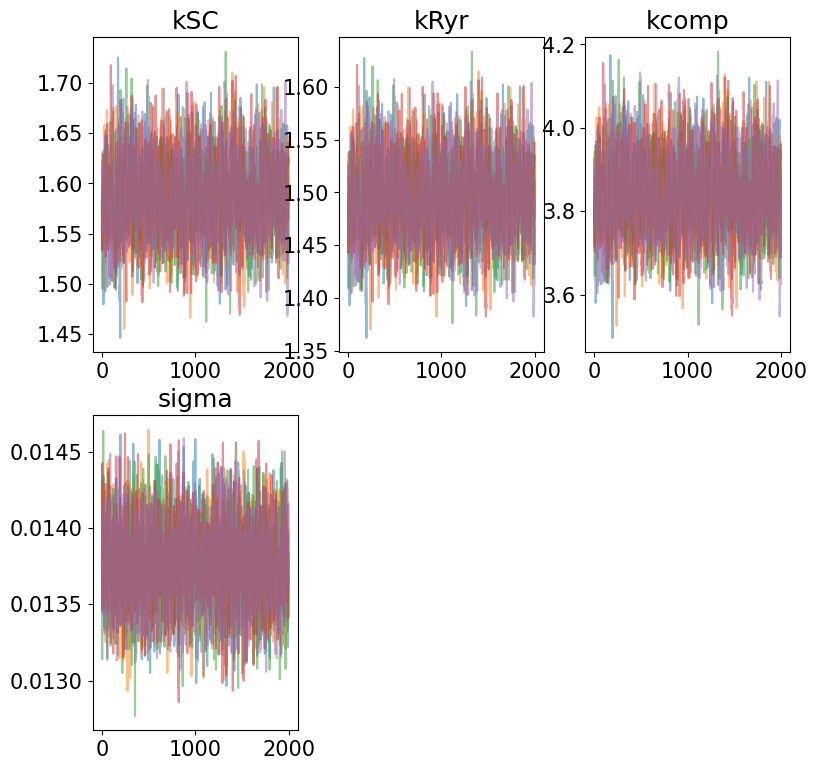

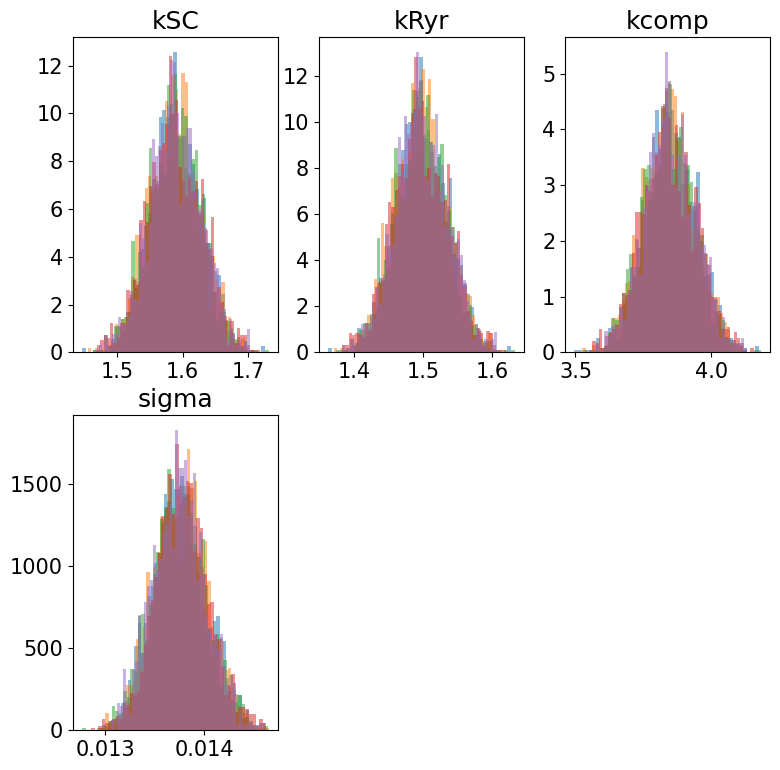

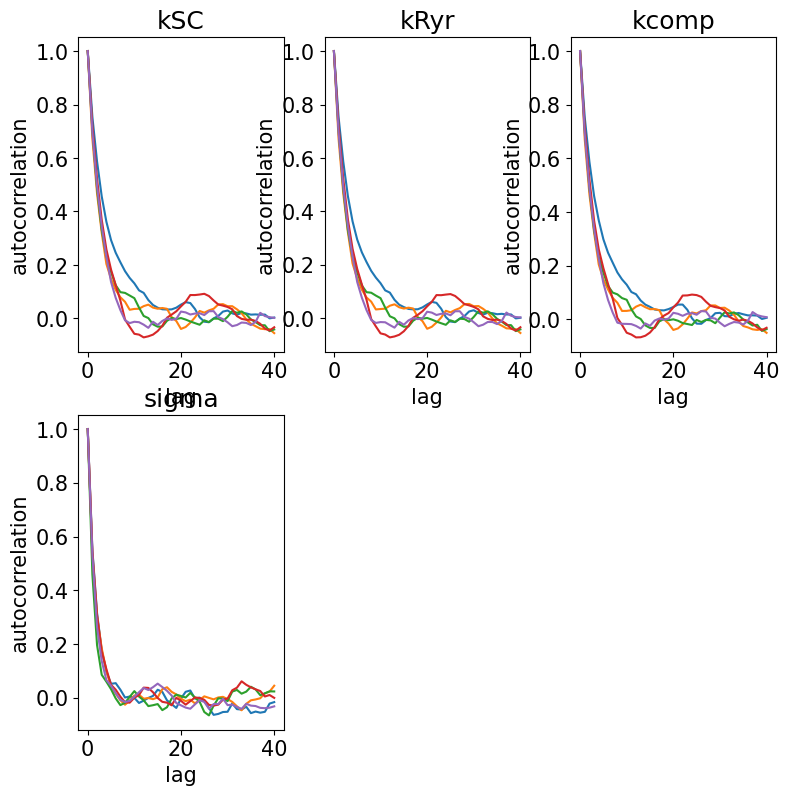

In [5]:
# expt data
numOfCells=4
numOfChains=5  
labels=['kSC','kRyr','kcomp','sigma']
cols=['blue','red','green','orange','purple','yellow','black']
numOfParams=len(labels)
skipList=[]

rcParams['figure.figsize']=9,9
rcParams['font.size']=15
fig4=plt.figure()  # sim

for cell in range(numOfCells):
    if cell not in skipList:
        results=pickle.load(open('peak{}/results.pkl'.format(cell),'rb'))   
        numOfIters=len(results[labels[0]][0])
        burnIn=int(0*numOfIters)
        skipChains=[]
        varDicts=[]

        fig1=plt.figure()  # trace plot
        fig2=plt.figure()  # posterior
        fig3=plt.figure()  # autocorr

        #### trace plot ####
        for i,param in enumerate(labels):    
            ax1=fig1.add_subplot(int(numOfParams/3)+1,3,i+1)
            ax1.set_title(param)
            varDict=[]
            dat=results[param]   
            #print(param)
            for j in range(numOfChains):
                if j in skipChains:
                    continue
                else:
                    ax1.plot(dat[j][burnIn:],alpha=0.5)
                    avg=np.average(dat[j][burnIn:])
                    varDict.append(avg)
            #        print(avg)
            varDict=np.array(varDict)
            varDicts.append(varDict)    
        plt.tight_layout()
        varDicts=np.array(varDicts)

        #### posterior ####
        for i,param in enumerate(labels):    
            ax2=fig2.add_subplot(int(numOfParams/3)+1,3,i+1)
            ax2.set_title(param)
            #ax.set_xlim([0,2])
            # prior
            #prs=[]
            #for k in range(1000):
            #    pr=np.random.lognormal(mean=np.log(priors[param]),sigma=priors['{}_std'.format(param)])
            #    prs.append(pr)
            #histPr=ax2.hist(prs,bins=20,density=True)
            # posterior
            dat=results[param]
            for j in range(numOfChains):
                if j in skipChains:
                    continue
                else:
                    histPo=ax2.hist(dat[j][burnIn:],bins=50,alpha=0.5,density=True)
        plt.tight_layout()

        #### autocorrelation ####
        for i,param in enumerate(labels):
            dat=results[param]
            ax3=fig3.add_subplot(int(numOfParams/3)+1,3,i+1)
            ax3.set_xlabel('lag')
            ax3.set_ylabel('autocorrelation')
            ax3.set_title(param)
            for j in range(numOfChains):
                autocorr = sm.tsa.acf(dat[j][burnIn:],nlags=40,fft=False)
                ax3.plot(autocorr)

        #### sims ####
        ax4=fig4.add_subplot(int(numOfCells/2)+1,2,cell+1)
        ax4.set_ylabel('[Ca]')
        ax4.set_xlabel('time (s)')

        # to remove nan values
        cytoExpt=[]
        for i in exptDat[:,cell*2]:
            if i != i:  # if i is nan, ignore
                continue
            else:
                cytoExpt.append(i)

        erExpt=[]
        for i in exptDat[:,cell*2+1]:
            if i != i:  # if i is nan, ignore
                continue
            else:
                erExpt.append(i)
        
        # normalization
        cytoMax=np.max(cytoExpt)
        #cytoExpt-=np.min(cytoExpt)
        cytoExpt/=cytoMax
        #erExpt-=np.min(erExpt)
        erExpt/=cytoMax
        
        
        datLen=len(cytoExpt)
        tEnd=datLen*frameRate
        ts=np.linspace(0,tEnd,datLen)
        ax4.plot(ts,cytoExpt,lw=3,color='tab:blue',alpha=0.5)
        ax4.plot(ts,erExpt,lw=3,color='tab:orange',alpha=0.5)

        for chain in range(numOfChains):
            y0s=[cytoExpt[0],3.0e-1,erExpt[0]]
            sim = odeint(cicr,y0s,ts,args=(varDicts[:,chain],)) 
            cyto=sim[:,0] 
            er=sim[:,2]
            
            cytoMax=np.max(cytoExpt)
            #cyto-=np.min(cyto)
            cyto/=cytoMax
            #er-=np.min(er)
            er/=cytoMax
            
            ax4.plot(ts,cyto,color='tab:blue',label='cytosolic Ca')
            ax4.plot(ts,er,color='tab:orange', label='ER Ca')

fig4.tight_layout()
fig4.savefig('cicr_fit.png')
            